# introduction

1. 首先我用一个简单的demo为你展示神经网络训练的过程：
   - 数据准备
   - 网络搭建
   - 利用反向传播算法迭代更新参数：
      - optimizer.zero_grad() 清空过往梯度；
      - loss.backward() 反向传播，计算当前梯度；
      - optimizer.step() 根据梯度更新网络参数
2. 然后我已以mnist为例为你展示一个稍复杂一点的网络

# 神经网络demo

## 数据准备

In [144]:
import torch
import torch.nn as nn

#前两个样本标签是一类，标签为0;后两个样本是一类，标签为1
sample_num=2
x=torch.tensor([[-1,-1.0],#-1.0是让数据类型变成float，而不是int
                [-2,-3],
                [3,2],
                [3,4]])
y=torch.tensor([-1.0,-1,1,1])

print(' x:{} \n y:{}'.format(x,y))

 x:tensor([[-1., -1.],
        [-2., -3.],
        [ 3.,  2.],
        [ 3.,  4.]]) 
 y:tensor([-1., -1.,  1.,  1.])


## 网络搭建

In [150]:
class net(nn.Module):
    def __init__(self):
        super(net,self).__init__()
        self.layer1=nn.Linear(2,5)#输入数据的维度为2，输出的维度为5
        self.layer2=nn.Linear(5,1)
        self.activation=nn.ReLU()
    
    def forward(self,x):
        x1=self.layer1(x)
        x2=self.activation(x1)
        y_pred=self.layer2(x2)
        return y_pred

## train

- 这个demo有问题，很可能达不到很好的准确率，这里只是让你了解宏观框架

In [149]:
model=net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)#这里定义了一个优化器,用来更新权重

for epoch in range(0,100):
    #清空之前内存里的梯度,如果不请空之前的梯度，梯度会一直累加
    optimizer.zero_grad()
    
    #将数据x输入到网络中，得到预测值。输入shape为(4,2)，输出shape为(4,1),4代表4条数据
    y_pred=model.forward(x)
    
    #这是我自己定义的损失函数，使用平方误差
    loss=torch.mean((y_pred-y)**2)
    
    #这行代码将自动计算各个变量的梯度，从loss开始一直到输入x，中间变量的梯度都会计算并暂存
    loss.backward()
    
    #这行代码将利用暂存的梯度去更新网络权重
    optimizer.step()
    
    #这是计算准确率
    accuracy=(torch.sum(y_pred[:sample_num]<0)+torch.sum(y_pred[sample_num:]>0)).float()/(sample_num*2)
    print('epoch{} loss: {} acc:{}'.format(epoch,loss.item(),accuracy))

epoch0 loss: 1.0473737716674805 acc:0.0
epoch1 loss: 1.0472602844238281 acc:0.0
epoch2 loss: 1.047147274017334 acc:0.0
epoch3 loss: 1.047034740447998 acc:0.0
epoch4 loss: 1.0469223260879517 acc:0.0
epoch5 loss: 1.046810507774353 acc:0.0
epoch6 loss: 1.046699047088623 acc:0.0
epoch7 loss: 1.0465879440307617 acc:0.0
epoch8 loss: 1.046477198600769 acc:0.0
epoch9 loss: 1.0463670492172241 acc:0.0
epoch10 loss: 1.0462568998336792 acc:0.0
epoch11 loss: 1.0461472272872925 acc:0.0
epoch12 loss: 1.046038031578064 acc:0.0
epoch13 loss: 1.0459290742874146 acc:0.0
epoch14 loss: 1.045820713043213 acc:0.0
epoch15 loss: 1.0457124710083008 acc:0.0
epoch16 loss: 1.0456045866012573 acc:0.0
epoch17 loss: 1.0454972982406616 acc:0.0
epoch18 loss: 1.045390248298645 acc:0.0
epoch19 loss: 1.0452836751937866 acc:0.0
epoch20 loss: 1.0451774597167969 acc:0.0
epoch21 loss: 1.0450713634490967 acc:0.0
epoch22 loss: 1.0449657440185547 acc:0.0
epoch23 loss: 1.044860601425171 acc:0.0
epoch24 loss: 1.0447556972503662 ac

# mnsit分类demo

- 参考网址：https://www.jianshu.com/p/ade6f9456ec5

## 数据准备

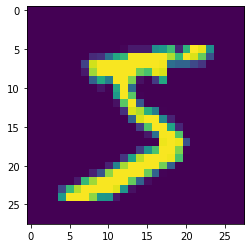

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

BATCH_SIZE=512 #每次打包512个数据，一起扔进网络
EPOCHS=5 # 总共训练的轮数
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 让torch判断是否使用GPU

#train_loader和test_loader使用pytorch内置的函数获取mnist数据，一开始会自动下载数据
#document:https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
#遇到不会的，你就优先查官方的documentation
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, #有数据集后改为download=False
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))#transform里面定义了对数据的预处理函数
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

#为你绘制一个数字
plt.imshow(train_loader.dataset.data[0,:,:])

## 网络搭建

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 二维卷积操作，输入通道为1，输出通道为10(意味着有10个卷积核，每次卷积核生成一个通道的数据)
        # 卷积核的大小是5*5的
        self.conv1=nn.Conv2d(1,10,5) 
        self.conv2=nn.Conv2d(10,20,3)
        
        #全连接层，输入是2000维向量，输出是500维向量
        self.fc1 = nn.Linear(20*10*10,500)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self,x):
        # 输入数据shape: 512,1,28,28 
        #其中521是batch_size,
        #1是一个颜色通道，这是灰度图，不是彩色的，只有一个通道
        #28,28分别是每幅图的长与宽
        in_size = x.size(0)#in_size=512
        out = self.conv1(x)
        out = F.relu(out)# relu是一种激活函数
        out = F.max_pool2d(out, 2, 2)  #最大池化操作，在2*2范围内找最大的那个值
        out = self.conv2(out)
        out = F.relu(out)
        out = out.view(in_size,-1)#view函数可以改变数据的shape，in_size=512,-1代表自动确定维度，这里将数据变成(512,?)的矩阵，?根据数据自动确定
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)# 文档：https://pytorch.org/docs/stable/nn.functional.html?highlight=log_softmax#torch.nn.functional.log_softmax
        return out

## train
我们在训练集上迭代更新网络参数，紧接着在测试集上测试网络的性能，可以看到经过5轮迭代，网络的能在测试集上达到99%的准确率

In [6]:
model = ConvNet().to(DEVICE)#如果你的电脑有GPU，这行代码将模型转到GPU上，方便加速计算
optimizer = optim.Adam(model.parameters())

#在训练集上迭代更新网络参数
def train(model, device, train_loader, optimizer, epoch):
    # batch_idx是代表第几个batch
    # data是图像数据，shape为(512,1,28,28)
    # target是标签值，shape为(512),其中每一个元素为一个整数值，代表类别标签
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)#将数据从内存转到GPU的显存中（如果有GPU）
        optimizer.zero_grad()
        output = model.forward(data)
        loss = F.nll_loss(output, target)#内置损失函数，文档：https://pytorch.org/docs/stable/nn.functional.html?highlight=nll_loss#torch.nn.functional.nll_loss
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%30 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

#在测试集上测试网络性能
def test(model, device, test_loader):
    model.eval()#测试时设置为evaluate模式，这样使用训练后得到的权重来测试网络性能
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)#正向计算预测值
            test_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()#找到正确的预测值
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
            
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.206701
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.164792
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.129204

Test set: Average loss: 0.0793, Accuracy: 9762/10000 (98%)

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.065975
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.070608
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.050992

Test set: Average loss: 0.0585, Accuracy: 9798/10000 (98%)

Train Epoch: 3 [14848/60000 (25%)]	Loss: 0.048688
Train Epoch: 3 [30208/60000 (50%)]	Loss: 0.041116
Train Epoch: 3 [45568/60000 (75%)]	Loss: 0.044716

Test set: Average loss: 0.0488, Accuracy: 9839/10000 (98%)

Train Epoch: 4 [14848/60000 (25%)]	Loss: 0.028931
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.036014
Train Epoch: 4 [45568/60000 (75%)]	Loss: 0.041002

Test set: Average loss: 0.0424, Accuracy: 9869/10000 (99%)

Train Epoch: 5 [14848/60000 (25%)]	Loss: 0.046034
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.024564
Train Epoch: 5 [45568/60000 (75%)]	Loss: 0.047217

Test 

## test
- 这里为你展示了测试集中的第一个图片是数字7，并且网络预测的结果也是7

label:7


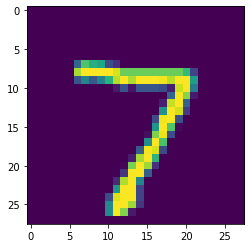

y_pred:tensor([7], device='cuda:0')


In [45]:
x,y=test_loader.dataset[0]

print('label:{}'.format(y))
plt.imshow(x[0,:,:].numpy())
plt.show()

x=x.view(1,1,28,28).to(DEVICE)
#这个y_pred的shape是(1,10)，代表1个数据，属于10类的概率，概率最高的那个类被认为是预测出来的类
y_pred=model.forward(x)
y_pred=torch.argmax(y_pred,dim=1)

print('y_pred:{}'.format(y_pred))